# Pre-load

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import ast
import eelbrain
import mne
import trftools
from scipy.io import wavfile
from sklearn import feature_selection
from scipy.stats import pearsonr

In [ ]:
# Path_JRB

DATA_ROOT = Path("~").expanduser() / 'Dropbox (University of Michigan)' / 'LittlePrince_trf'

In [2]:
# Path_JC

DATA_ROOT = Path("~").expanduser() / 'Data' / 'Tones'

In [3]:
# FIRST chapter of LPP divided into 11 wav files

#STIMULI = [str(i) for i in range(1, 12)]
WAV_DIR = DATA_ROOT / 'stimuli'
PREDICTOR_DIR = DATA_ROOT / 'predictors'
EEG_DIR = DATA_ROOT / 'eeg'

# Define a target directory for TRF estimates and make sure the directory is created
TRF_DIR = DATA_ROOT / 'TRFs'
TRF_DIR.mkdir(exist_ok=True)

In [5]:
# Load stimuli
# ------------
# Make sure to name the stimuli so that the TRFs can later be distinguished
# Load the gammatone-spectrograms; use the time axis of these as reference
gammatone = [eelbrain.load.unpickle(PREDICTOR_DIR / 'tonestest_gammatone-8.pickle')]

# Resample the spectrograms to 100 Hz (time-step = 0.01 s), which we will use for TRFs
gammatone = [x.bin(0.01, dim='time', label='start') for x in gammatone]

# Pad onset with 100 ms and offset with 1 second; make sure to give the predictor a unique name as that will make it easier to identify the TRF later
gammatone = [trftools.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='gammatone') for x in gammatone]

# Load the broad-band envelope and process it in the same way
envelope = [eelbrain.load.unpickle(PREDICTOR_DIR / 'tonestest_gammatone-1.pickle')]
envelope = [x.bin(0.01, dim='time', label='start') for x in envelope]
envelope = [trftools.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='envelope') for x in envelope]

onset_envelope = [eelbrain.load.unpickle(PREDICTOR_DIR / 'tonestest_gammatone-on-1.pickle')]
onset_envelope = [x.bin(0.01, dim='time', label='start') for x in onset_envelope]
onset_envelope = [trftools.pad(x, tstart=-0.100, tstop=x.time.tstop + 1, name='onset') for x in onset_envelope]

# Load onset spectrograms and make sure the time dimension is equal to the gammatone spectrograms
gammatone_onsets = [eelbrain.load.unpickle(PREDICTOR_DIR / 'tonestest_gammatone-on-8.pickle')]
gammatone_onsets = [x.bin(0.01, dim='time', label='start') for x in gammatone_onsets]
gammatone_onsets = [eelbrain.set_time(x, gt.time, name='gammatone_on') for x, gt in zip(gammatone_onsets, gammatone)]

# Load word tables and convert tables into continuous time-series with matching time dimension
#word_tables = [eelbrain.load.unpickle(PREDICTOR_DIR / f'{stimulus}~word.pickle') for stimulus in STIMULI]
#word_onsets = [eelbrain.event_impulse_predictor(gt.time, ds=ds, name='word') for gt, ds in zip(gammatone, word_tables)]

# Function and content word impulses based on the boolean variables in the word-tables
#word_lexical = [eelbrain.event_impulse_predictor(gt.time, value='lexical', ds=ds, name='lexical') for gt, ds in zip(gammatone, word_tables)]
#word_nlexical = [eelbrain.event_impulse_predictor(gt.time, value='nlexical', ds=ds, name='non_lexical') for gt, ds in zip(gammatone, word_tables)]

# Extract the duration of the stimuli, so we can later match the EEG to the stimuli
#gt_durations = [gt.time.tmax for stimulus, gt in zip(STIMULI, gammatone)]

In [7]:
# get raw wav file durations for reference
wav_durations = []
samplerate, data = wavfile.read(WAV_DIR / '1000Hz_300ms.wav')
wav_durations.append(len(data) / samplerate) 

In [6]:
# Models
# ------
# Pre-define models here to have easier access during estimation. In the future, additional models could be added here and the script re-run to generate additional TRFs.
models = {
    # Acoustic models
    'envelope': [envelope],
#    'envelope+onset': [envelope, onset_envelope],
#    'acoustic': [gammatone, gammatone_onsets],
    # Models with word-onsets and word-class
#    'words': [word_onsets],
#    'words+lexical': [word_onsets, word_lexical, word_nlexical],
#    'acoustic+words': [gammatone, gammatone_onsets, word_onsets],
#    'acoustic+words+lexical': [gammatone, gammatone_onsets, word_onsets, word_lexical, word_nlexical],
}

# Load & preprocess EEG

In [9]:
raw = mne.io.read_raw_brainvision(EEG_DIR / 'R0748_20200311_TonesTest_0030.vhdr', preload=True)

C:\Users\LG\AppData\Local\Temp\ipykernel_18328\3018014566.py:1: RuntimeWarning: No coordinate information found for channels ['AUD']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(EEG_DIR / 'R0748_20200311_TonesTest_0030.vhdr', preload=True)
C:\Users\LG\AppData\Local\Temp\ipykernel_18328\3018014566.py:1: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(EEG_DIR / 'R0748_20200311_TonesTest_0030.vhdr', preload=True)
C:\Users\LG\AppData\Local\Temp\ipykernel_18328\3018014566.py:1: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(EEG_DIR / 'R0748_20200311_TonesTest_0030.vhdr', preload=True)
C:\Users\LG\AppData\Local\Temp\ipykernel_18328\3018014566.py:1: RuntimeWarning: Not setting positions of 2 misc channels found in mo

In [10]:
eeg = raw.copy().pick_types(eeg=True)

# Filter

eeg.filter(0.5, 20)

#Rereference

eeg.add_reference_channels('TP9')
eeg.set_eeg_reference(ref_channels = ['TP9', 'TP10'])

# Pick EEG channels

eeg = eeg.pick_types(eeg=True, meg=False, exclude=['VEOG', 'OPTO', 'AUD'])

# Set montage

#montage = mne.channels.read_custom_montage(DATA_ROOT / 'easycapM10-acti61_elec.sfp')
#eeg.set_montage(montage, on_missing='ignore')

C:\Users\LG\AppData\Local\Temp\ipykernel_18328\3804585644.py:9: RuntimeWarning: The locations of multiple reference channels are ignored.
  eeg.add_reference_channels('TP9')


In [63]:
#eeg.info['ch_names']

In [10]:
%matplotlib

eeg.plot()

Using matplotlib backend: <object object at 0x000002098B239740>


In [20]:
#butterfly plot
eeg.pick_types(eeg=True).plot(butterfly=True, start = 0.0, duration = 20.0, scalings = dict(eeg=100e-6));

In [10]:
# Bad channels interpolation
bad_ch = []
for ch in bad_ch:
    eeg.info['bads'].append(ch) 

eeg.interpolate_bads()

<RawBrainVision | R0443_20170525_LittlePrinceEEG_01.eeg, 61 x 278358 (556.7 s), ~129.6 MB, data loaded>

In [ ]:
eeg.plot()

In [11]:
# ICA 

filt_raw = eeg.copy().filter(l_freq=1., h_freq=None)
ica = mne.preprocessing.ICA(n_components=25, max_iter='auto', random_state=97)
ica.fit(filt_raw)
ica

Method,fastica
Fit,42 iterations on raw data (72010 samples)
ICA components,25
Explained variance,99.9 %
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


In [13]:
filt_raw.load_data()
ica.plot_sources(filt_raw, show_scrollbars=True);

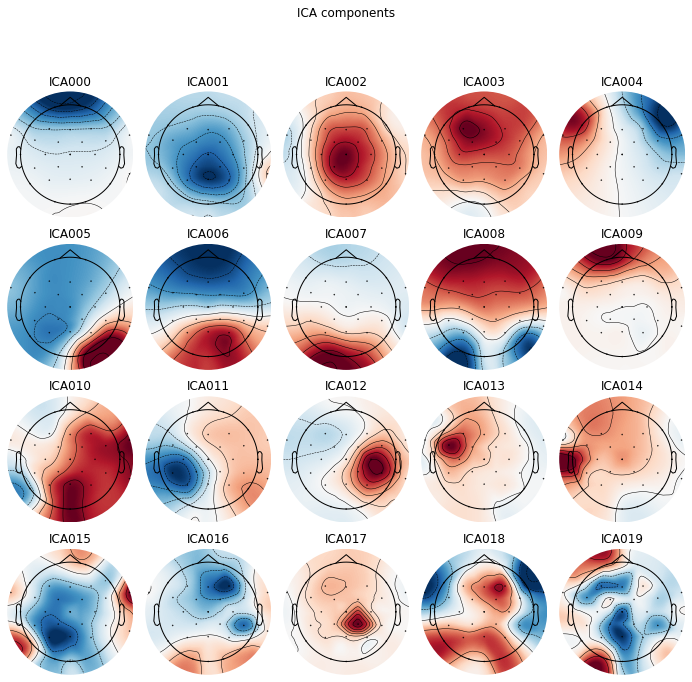

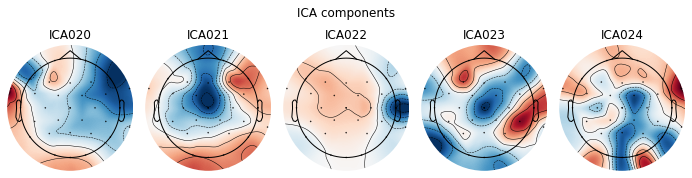

[<MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x187.56 with 5 Axes>]

In [12]:
ica.plot_components()

In [14]:
ica.exclude = [0, 4] #R0748

eeg_noica = eeg.copy()
ica.apply(eeg)

<RawBrainVision | R0748_20200311_TonesTest_0030.eeg, 32 x 72010 (144.0 s), ~17.6 MB, data loaded>

In [ ]:
%matplotlib
eeg.plot()

In [73]:
eeg.pick_types(eeg=True).plot(butterfly=True, start = 0.0, duration = 20.0, scalings = dict(eeg=100e-6));

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 270, in process
    func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/mne/viz/_mpl_figure.py", line 511, in _resize
    old_width, old_height = self.mne.fig_size_px
AttributeError: 'BrowserParams' object has no attribute 'fig_size_px'


In [15]:
eeg.save(DATA_ROOT / 'R0748_preprocessed_raw.fif', overwrite=False)

# AUD channel alignment

In [16]:
# AUD

aud = raw.copy().pick_channels(['AUD'])

In [31]:
aud.set_channel_types(mapping={'AUD': 'eeg'});

C:\Users\LG\AppData\Local\Temp\ipykernel_18328\262215726.py:1: RuntimeWarning: The unit for channel(s) AUD has changed from NA to V.
  aud.set_channel_types(mapping={'AUD': 'eeg'});


In [41]:
aud.plot()

In [32]:
event_id = {'onset': 1}
events   = mne.events_from_annotations(aud)
events   = events[0]
ds_sfreq = 100 # defined when predictors are created

aud_epochs = mne.Epochs(aud, events, event_id, 
                        tmin=-0.1, tmax=len(predictors_concatenated[0])/ds_sfreq,  
                        baseline=(None,0.), preload=True)

In [20]:
aud_epochs

Number of events,120
Events,onset: 120
Time range,-0.100 – 1.000 sec
Baseline,-0.100 – 0.000 sec


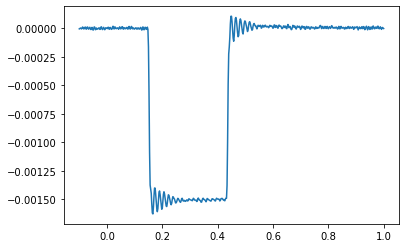

In [33]:
# AUD channel plot

y = aud_epochs.get_data()[0][0][0:1000]
t = aud_epochs.times[0:1000]
plt.plot(t, y)

In [34]:
# Resample and concatenate aud

aud_downsampled = aud_epochs[0].copy().resample(sfreq=ds_sfreq)
aud_ndvar         = eelbrain.load.fiff.epochs_ndvar(aud_downsampled, -0.100, connectivity='none')
aud_concatenated  = eelbrain.concatenate(aud_ndvar)

In [23]:
for model, predictors in models.items():
    # Select and concetenate the predictors corresponding to the EEG trials
    predictors_concatenated = []
    for predictor in predictors:
        predictors_concatenated.append(eelbrain.concatenate([predictor[0]]))

In [40]:
aud_concatenated.get_dim('time')

UTS(0.0, 0.01, 110)

In [24]:
predictors_concatenated[0].get_dim('time') 

UTS(0.0, 0.01, 138)

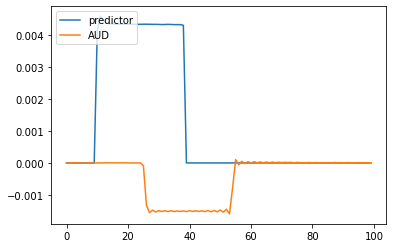

In [39]:
# Plot predictors_con and aud_con (same time intervals)

%matplotlib inline

X = range(0, 100) # X axis in 100 Hz samples
#X = range(50000, 50050)
plt.plot(X, predictors_concatenated[0].x[X]/100000, label='predictor')
plt.plot(X, aud_concatenated.x[0][X], label='AUD')
plt.legend(loc="upper left")

plt.show()

In [98]:
# Correlation

corr_ls = [[] for _ in range(120)]
lags = []

for s in range(0, 80):

    shift_by = s
    shift_by_sec = shift_by / ds_sfreq

    events_shft = []
    #aud_crop = aud.copy().crop(tmin=0, tmax=10)
    events   = mne.events_from_annotations(aud)
    events   = events[0]

    for i in range(len(events)-1):
        events_shft[i:i+1] = mne.event.shift_time_events(events[i:i+1], 
                                                         ids=None, 
                                                         tshift=shift_by_sec, 
                                                         sfreq=raw.info['sfreq'])
    events_shift_arr = np.vstack(events_shft)
    aud_epochs_shifted = mne.Epochs(aud, events_shift_arr, event_id, tmin=0, tmax=len(predictors_concatenated[0])/ds_sfreq, 
                                    baseline=(0,0.), preload=True)
    lags.append(shift_by_sec)
    
    for e in range(len(aud_epochs_shifted)):

        aud_shifted_downsampled = aud_epochs_shifted[e].copy().resample(sfreq=ds_sfreq) 
        aud_shifted_rotated = np.flipud(np.rot90( aud_shifted_downsampled.get_data()[0] ))

        corr, _ = pearsonr(np.squeeze(aud_shifted_rotated), predictors_concatenated[0].x)  
        corr_ls[e].append(corr)
        
#idx = np.argmax(np.array(corr_ls))
#max_lag.append(lags[idx])

In [116]:
max_lag = [0]

for i in range(len(corr_ls)-1):
    idx = np.argmax(np.array(corr_ls[i]))
    max_lag.append(lags[idx])

In [117]:
max_lag

[0,
 0.35,
 0.32,
 0.31,
 0.32,
 0.31,
 0.32,
 0.32,
 0.32,
 0.32,
 0.32,
 0.31,
 0.32,
 0.32,
 0.32,
 0.32,
 0.32,
 0.31,
 0.31,
 0.32,
 0.31,
 0.32,
 0.32,
 0.32,
 0.32,
 0.32,
 0.32,
 0.32,
 0.32,
 0.31,
 0.32,
 0.31,
 0.32,
 0.32,
 0.32,
 0.31,
 0.31,
 0.32,
 0.32,
 0.32,
 0.32,
 0.32,
 0.31,
 0.31,
 0.32,
 0.31,
 0.32,
 0.32,
 0.31,
 0.31,
 0.32,
 0.32,
 0.32,
 0.32,
 0.32,
 0.31,
 0.32,
 0.31,
 0.32,
 0.32,
 0.32,
 0.31,
 0.32,
 0.32,
 0.32,
 0.32,
 0.32,
 0.31,
 0.31,
 0.32,
 0.32,
 0.31,
 0.31,
 0.32,
 0.32,
 0.32,
 0.31,
 0.31,
 0.32,
 0.32,
 0.31,
 0.32,
 0.32,
 0.32,
 0.31,
 0.31,
 0.32,
 0.32,
 0.32,
 0.32,
 0.32,
 0.31,
 0.31,
 0.32,
 0.31,
 0.32,
 0.32,
 0.31,
 0.32,
 0.31,
 0.32,
 0.31,
 0.31,
 0.31,
 0.32,
 0.32,
 0.32,
 0.31,
 0.32,
 0.31,
 0.32,
 0.32,
 0.32,
 0.31,
 0.31,
 0.32,
 0.31,
 0.32,
 0.32,
 0.32]

In [120]:
# shift events according to max_lag

for i in range(len(events)-1):
    
    events_shft[i:i+1] = mne.event.shift_time_events(events[i:i+1], 
                                                         ids=None, 
                                                         tshift=max_lag[i], 
                                                         sfreq=raw.info['sfreq'])
    events_shift_arr = np.vstack(events_shft)
    aud_epochs_shifted = mne.Epochs(aud, events_shift_arr, event_id, tmin=0, tmax=len(predictors_concatenated[0])/ds_sfreq, 
                                    baseline=(0,0.), preload=True)

# Shift EEG

In [125]:
event_id={'onset': 1}
epochs = mne.Epochs(eeg, events_shift_arr, event_id, tmin=-0.1, tmax=len(predictors_concatenated[0])/ds_sfreq-0.1, baseline=(None,0.), preload=True)

In [126]:
# Resample and concatenate

eeg_epoch_downsampled     = epochs.copy().resample(sfreq=100)
eeg_shifted               = eelbrain.load.fiff.epochs_ndvar(eeg_epoch_downsampled, -0.100, connectivity='auto')
eeg_shifted_concatenated  = eelbrain.concatenate(eeg_shifted)

In [127]:
eeg_shifted_concatenated.get_dim("time")

UTS(0.0, 0.01, 16422)

In [124]:
predictors_concatenated[0].get_dim("time") #16422/138 = 119

UTS(0.0, 0.01, 138)

In [145]:
# Concatenate envelopes (119 times)
envelope_ls = []
for i in range(119):
    envelope_ls.append(eelbrain.concatenate(envelope))

In [149]:
indices = np.arange(0, 119)
envelopes_concatenated = []
envelopes_concatenated.append(eelbrain.concatenate([envelope_ls[i] for i in indices]))

In [151]:
envelopes_concatenated[0].get_dim("time")

UTS(0.0, 0.01, 16422)

# Fit TRF

In [162]:
eelbrain.configure(n_workers=False)

trf = eelbrain.boosting(eeg_shifted_concatenated, envelopes_concatenated, 
                        -0.100, 1.000, error='l1', 
                        basis=0.050, partitions=5, test=1, selective_stopping=True)

Fitting models:   0%|          | 0/640 [00:00<?, ?it/s]

In [163]:
eelbrain.save.pickle(trf, TRF_DIR / 'tonestest_trf.pickle' )

# Figure

cf. boosting result: https://eelbrain.readthedocs.io/en/stable/generated/eelbrain.BoostingResult.html

In [154]:
import re
import os
import trftools
from scipy.io import loadmat
from eelbrain import *
from matplotlib import pyplot

In [ ]:
#trf = load.unpickle(TRF_DIR/'tonestest_trf.pickle')

ValueError: Points cannot contain NaN

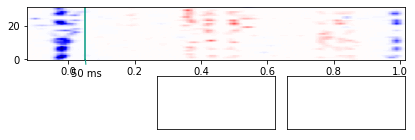

In [164]:
p = plot.TopoArray(trf.h, w=6, h=2, t=(.050, .150, .350))

<IPython.core.display.Javascript object>


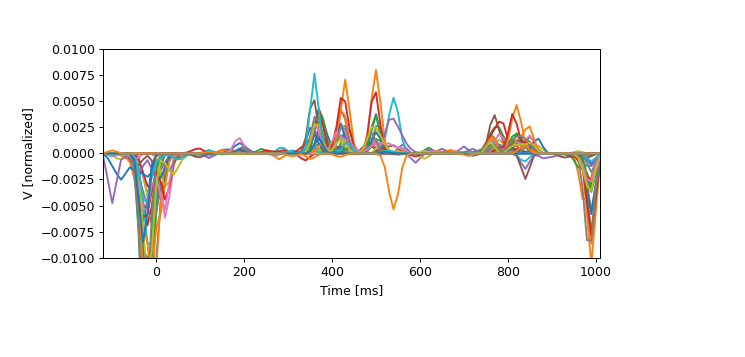

ValueError: Points cannot contain NaN

In [169]:
%matplotlib notebook
p = plot.TopoButterfly(trf.h, w=6, h=2, vmax = 0.01)
#p.set_time(.2)

In [ ]:
plt.savefig("mi_subject0.jpg")